# Dataset generated from the segmaneted frames contained in ScanNet directly

In [1]:
import os
import subprocess

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio.v2 as imageio
import open3d as o3d
import cv2

import json
import zipfile

current_directory = os.getcwd()

## File Extraction / Unzipping Intructions
**Note:** These steps should be performed only at the beginning of the process.

In [2]:
scans_directory = os.path.join(current_directory, "data/scans")
output_dir = os.path.join(current_directory, "outputs/reader")

def run_reader(filename, output_path):
    command = [
        "python",
        "scripts/SensReader/reader.py",
        "--filename",
        filename,
        "--output_path",
        output_path,
        #"--export_depth_images",
        "--export_color_images"
        #"--export_poses",
        #"--export_intrinsics"
    ]
    subprocess.run(command)

for folder in os.listdir(scans_directory):
    if folder.startswith("scene"):
        sensor_file = os.path.join(scans_directory, folder, f"{folder}.sens")
        output_path = os.path.join(output_dir, folder)
        if os.path.isfile(sensor_file):
            run_reader(sensor_file, output_path)
        else:
            print(f"Sensor file not found for {folder}")

zip_files_dir = os.path.join(current_directory, "data/scans")
output_dir = os.path.join(current_directory, "outputs/2d-zip")

def unzip_file(zip_file_path, output_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

for folder in os.listdir(zip_files_dir):
    if folder.startswith("scene"):
        zip_file = os.path.join(scans_directory, folder, f"{folder}_2d-instance-filt.zip")
        output_path = os.path.join(output_dir, f"{folder}")
        unzip_file(zip_file, output_path)

Namespace(filename='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0003_00/scene0003_00.sens', output_path='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0003_00', export_depth_images=False, export_color_images=True, export_poses=False, export_intrinsics=False)
loading /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0003_00/scene0003_00.sens...loaded!
exporting 1736 color frames to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0003_00/color


KeyboardInterrupt: 

## Select scene, class and instance

In [2]:
scene = "scene0000_00"

scene_path = os.path.join(current_directory, "data/scans", scene)

The class must be chosen among one of the raw_category in the [scannetv2-labels.combinesd.tsv](data/scannetv2-labels.combined.tsv)

In [3]:
with open(os.path.join(scene_path, scene + '.aggregation.json')) as f:
    aggregation_data = json.load(f)

all_classes = set()
for seg_group in aggregation_data['segGroups']:
    all_classes.add(seg_group['label'])

print("All labels in the aggregation data: ", all_classes)

All labels in the aggregation data:  {'ceiling', 'refrigerator', 'floor', 'shower', 'coffee table', 'kitchen cabinets', 'bicycle', 'shelf', 'stool', 'mirror', 'shoes', 'cabinet', 'doorframe', 'kitchen counter', 'guitar', 'door', 'toilet', 'tv', 'table', 'pillow', 'toaster', 'microwave', 'desk', 'dish rack', 'curtain', 'wall', 'nightstand', 'couch', 'tissue box', 'object', 'toaster oven', 'clock', 'trash can', 'backpack', 'window', 'scale', 'bed', 'laundry basket', 'guitar case', 'sink'}


In [64]:
class_name = 'coffee table'

with open(os.path.join(scene_path, scene + '.aggregation.json')) as f:
    aggregation_data = json.load(f)

object_ids = []

for seg_group in aggregation_data['segGroups']:
    if seg_group['label'] == class_name:
        object_ids.append(seg_group['objectId'])

if not object_ids:
    print("No objects found for class:", class_name)
else:
    print(f"Found {len(object_ids)} objects for class {class_name}: {object_ids}")

Found 1 objects for class coffee table: [34]


In [61]:
instance_id = 36

instance_id = instance_id + 1
map_file = os.path.join(current_directory, "data/scannetv2-labels.combined.tsv")
instances_dir = os.path.join(current_directory, "outputs/2d-zip", scene, "instance-filt")
original_dir = os.path.join(current_directory, "outputs/reader", scene, "color")

def get_labels(instances_img):
    labels = instances_img // 1000
    return labels.astype(np.uint8)

def get_instances(instances_img):
    ids = instances_img % 1000
    return ids.astype(np.uint8)

## Example

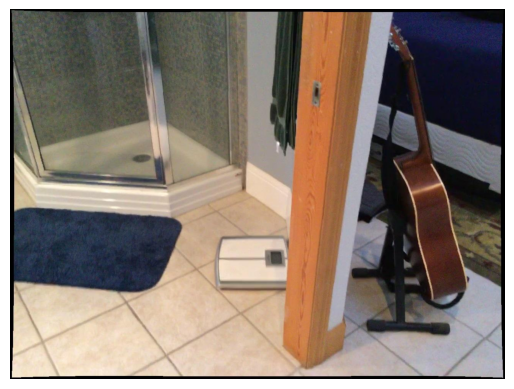

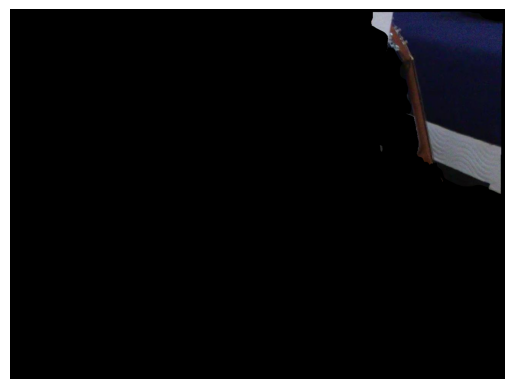

In [20]:
instances_img_path = os.path.join(instances_dir, "4070.png")
original_img_path = os.path.join(original_dir, "4070.jpg")

instances_img = imageio.imread(instances_img_path)
original_img = imageio.imread(original_img_path)

instance_ids = get_instances(instances_img)
binary_mask = (instance_ids == instance_id).astype(np.uint8)

masked_img = original_img * binary_mask[:, :, None]

plt.imshow(original_img)
plt.axis('off')
plt.show()

plt.imshow(masked_img)
plt.axis('off')
plt.show()

## Get masked images

### Select minimum_points in an image

In [62]:
minimum_points = 50000

### Save masked frames

In [63]:
masked_images_directory = os.path.join(current_directory, "outputs/masked_images/direct/"+scene, f"{instance_id-1}")
if not os.path.exists(masked_images_directory):
    os.makedirs(masked_images_directory)

for filename in os.listdir(instances_dir):
    frame = filename.split('.')[0]
    instances_frame_path = os.path.join(instances_dir, f"{frame}.png")
    original_frame_path = os.path.join(original_dir, f"{frame}.jpg")

    instances_img = imageio.imread(instances_frame_path)
    original_img = imageio.imread(original_frame_path)

    instance_ids = get_instances(instances_img)
    binary_mask = (instance_ids == instance_id).astype(np.uint8)

    if np.sum(binary_mask != 0) > minimum_points:
        masked_img = original_img * binary_mask[:, :, None]
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR)
        output_path = os.path.join(masked_images_directory, f"{int(frame):05d}.jpg")
        cv2.imwrite(output_path, masked_img)
